In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = Main.CoherentStructures.interpolateVF_linearBC(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
nevs                   = 10
ϵ                      = 0.1
num_steps              = 250
t_initial              = minimum(Time)
t_end                  = t_initial+70     # parameter value corresponding to ϵ=0 (t_max is 90)
wind_scale             = 1e-5
wind_center            = 30
solver_tolerance       = 1e-6
solver                 = OrdinaryDiffEq.BS5();

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
nothing

 83.015127 seconds (96.93 M allocations: 5.463 GiB, 2.02% gc time)


In [10]:
evs = zeros(num_steps+1,nevs)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=nevs, which=:SM);

In [11]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_flow_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
    DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
    evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

 70.011109 seconds (60.68 M allocations: 3.321 GiB, 0.90% gc time)
 70.014395 seconds (60.48 M allocations: 3.308 GiB, 0.86% gc time)
1/125
 66.060691 seconds (45.28 M allocations: 2.663 GiB, 0.58% gc time)
 68.170863 seconds (45.28 M allocations: 2.663 GiB, 0.57% gc time)
2/125
 67.019911 seconds (45.28 M allocations: 2.663 GiB, 1.20% gc time)
 66.337768 seconds (45.28 M allocations: 2.663 GiB, 0.52% gc time)
3/125
 66.334469 seconds (45.28 M allocations: 2.663 GiB, 0.51% gc time)
 66.036359 seconds (45.28 M allocations: 2.663 GiB, 0.54% gc time)
4/125
 66.741350 seconds (45.28 M allocations: 2.663 GiB, 0.51% gc time)
 66.508234 seconds (45.28 M allocations: 2.663 GiB, 0.52% gc time)
5/125
 66.457269 seconds (45.28 M allocations: 2.663 GiB, 0.52% gc time)
 66.160771 seconds (45.28 M allocations: 2.663 GiB, 0.48% gc time)
6/125
 66.186296 seconds (45.28 M allocations: 2.663 GiB, 0.48% gc time)
 66.813266 seconds (45.28 M allocations: 2.663 GiB, 0.52% gc time)
7/125
 65.180897 seconds (

 65.710761 seconds (45.28 M allocations: 2.663 GiB, 0.48% gc time)
 66.418385 seconds (45.28 M allocations: 2.663 GiB, 0.51% gc time)
59/125
 66.363466 seconds (45.28 M allocations: 2.663 GiB, 1.10% gc time)
 65.418478 seconds (45.28 M allocations: 2.663 GiB, 0.46% gc time)
60/125
 65.983692 seconds (45.28 M allocations: 2.663 GiB, 0.50% gc time)
 65.875726 seconds (45.28 M allocations: 2.663 GiB, 0.50% gc time)
61/125
 66.072340 seconds (45.28 M allocations: 2.663 GiB, 0.48% gc time)
 66.005576 seconds (45.28 M allocations: 2.663 GiB, 0.51% gc time)
62/125
 66.046601 seconds (45.28 M allocations: 2.663 GiB, 0.50% gc time)
 66.442378 seconds (45.28 M allocations: 2.663 GiB, 0.52% gc time)
63/125
 65.826642 seconds (45.28 M allocations: 2.663 GiB, 0.47% gc time)
 66.085561 seconds (45.28 M allocations: 2.663 GiB, 0.51% gc time)
64/125
 66.032685 seconds (45.28 M allocations: 2.663 GiB, 0.49% gc time)
 65.986066 seconds (45.28 M allocations: 2.663 GiB, 0.49% gc time)
65/125
 65.969706 se

 64.430409 seconds (45.28 M allocations: 2.663 GiB, 0.46% gc time)
 63.809635 seconds (45.28 M allocations: 2.663 GiB, 0.45% gc time)
117/125
 64.257841 seconds (45.28 M allocations: 2.663 GiB, 0.44% gc time)
 63.943828 seconds (45.28 M allocations: 2.663 GiB, 0.48% gc time)
118/125
 64.513683 seconds (45.28 M allocations: 2.663 GiB, 1.03% gc time)
 64.000198 seconds (45.28 M allocations: 2.663 GiB, 0.45% gc time)
119/125
 64.891025 seconds (45.28 M allocations: 2.663 GiB, 0.46% gc time)
 64.636240 seconds (45.28 M allocations: 2.663 GiB, 0.46% gc time)
120/125
 65.168246 seconds (45.28 M allocations: 2.663 GiB, 0.47% gc time)
 64.646647 seconds (45.28 M allocations: 2.663 GiB, 0.47% gc time)
121/125
 65.244132 seconds (45.28 M allocations: 2.663 GiB, 0.47% gc time)
 65.154373 seconds (45.28 M allocations: 2.663 GiB, 0.47% gc time)
122/125
 64.694647 seconds (45.28 M allocations: 2.663 GiB, 0.47% gc time)
 64.383864 seconds (45.28 M allocations: 2.663 GiB, 0.46% gc time)
123/125
 64.51

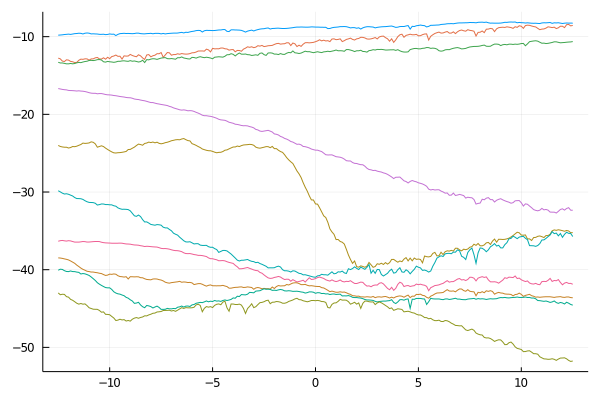

In [12]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

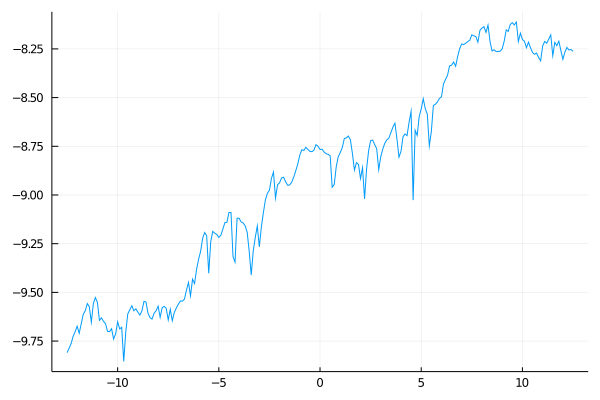

In [13]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1], legend=false, fmt = :png)

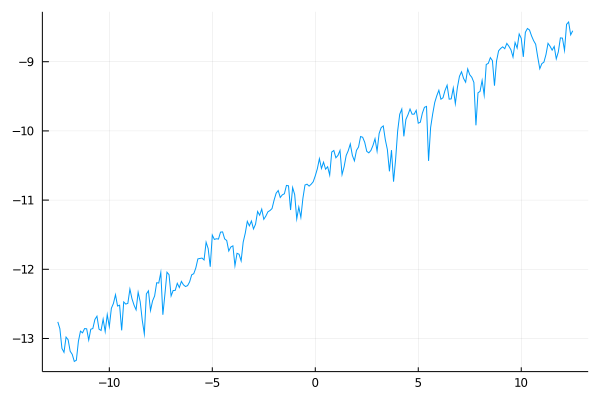

In [14]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

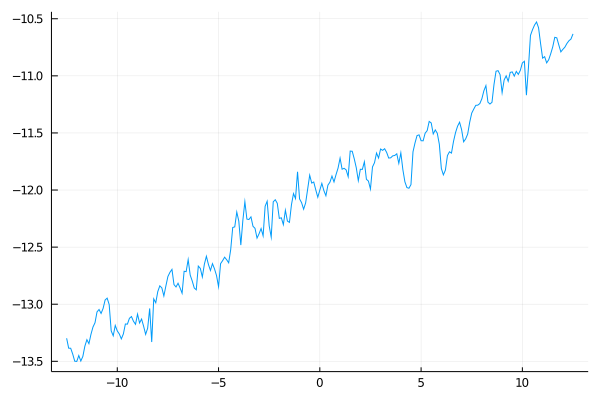

In [15]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,3], legend=false, fmt = :png)

In [16]:
[range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs]

251×11 Array{Float64,2}:
 -12.5  -9.80946  -12.7601   -13.2981  …  -38.4763  -40.0704  -42.9877
 -12.4  -9.78754  -12.859    -13.385      -38.4982  -39.937   -43.2231
 -12.3  -9.76326  -13.1438   -13.3857     -38.5422  -39.9667  -43.159
 -12.2  -9.72579  -13.1998   -13.4367     -38.6082  -40.1265  -43.1804
 -12.1  -9.70145  -12.9804   -13.4991     -38.6652  -40.2269  -43.4703
 -12.0  -9.67375  -13.018    -13.501   …  -38.7426  -40.2477  -43.5324
 -11.9  -9.71016  -13.1844   -13.4493     -38.8746  -40.1617  -43.8198
 -11.8  -9.66137  -13.2297   -13.4975     -39.0257  -40.2428  -43.9361
 -11.7  -9.613    -13.3317   -13.4574     -39.1787  -40.2473  -44.119
 -11.6  -9.59458  -13.3147   -13.3672     -39.409   -40.3075  -44.3158
 -11.5  -9.55747  -13.0402   -13.3106  …  -39.5928  -40.3436  -44.4334
 -11.4  -9.57384  -12.8942   -13.3455     -39.7933  -40.5531  -44.3518
 -11.3  -9.65277  -12.9186   -13.2643     -39.9536  -40.4939  -44.4388
   ⋮                                   ⋱              

In [17]:
evs

251×10 Array{Float64,2}:
 -9.80946  -12.7601   -13.2981  -16.6807  …  -38.4763  -40.0704  -42.9877
 -9.78754  -12.859    -13.385   -16.7337     -38.4982  -39.937   -43.2231
 -9.76326  -13.1438   -13.3857  -16.7898     -38.5422  -39.9667  -43.159
 -9.72579  -13.1998   -13.4367  -16.8279     -38.6082  -40.1265  -43.1804
 -9.70145  -12.9804   -13.4991  -16.8506     -38.6652  -40.2269  -43.4703
 -9.67375  -13.018    -13.501   -16.92    …  -38.7426  -40.2477  -43.5324
 -9.71016  -13.1844   -13.4493  -16.9382     -38.8746  -40.1617  -43.8198
 -9.66137  -13.2297   -13.4975  -16.9472     -39.0257  -40.2428  -43.9361
 -9.613    -13.3317   -13.4574  -16.9688     -39.1787  -40.2473  -44.119
 -9.59458  -13.3147   -13.3672  -16.998      -39.409   -40.3075  -44.3158
 -9.55747  -13.0402   -13.3106  -16.9694  …  -39.5928  -40.3436  -44.4334
 -9.57384  -12.8942   -13.3455  -17.0052     -39.7933  -40.5531  -44.3518
 -9.65277  -12.9186   -13.2643  -17.0228     -39.9536  -40.4939  -44.4388
  ⋮            

In [18]:
using DelimitedFiles

In [19]:
writedlm("D:/ocean_wind_"*string(grid_resolution)*"_"*string(Integer(num_steps/2)*ϵ)*"_"*string(t_end-t_initial)*".csv", [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")